# 가짜연구소 4기 - 추천시스템 톺아보기
## Item2Vec / LDA(Latent Dirichlet Allocation)
- 데이터 출처: https://www.kaggle.com/code/jneupane12/analysis-of-movielens-dataset-beginner-sanalysis/data

## 패키지

In [1]:
%matplotlib inline

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from gensim import corpora
from gensim.models import Word2Vec
from gensim.models.ldamodel import LdaModel

from gensim.models.callbacks import CoherenceMetric 
from gensim.models.callbacks import PerplexityMetric
from gensim.models.coherencemodel import CoherenceModel 

from datetime import datetime

In [2]:
path = "../data/MovieLens/ratings.csv"
df = pd.read_csv(path)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51
...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22
100832,610,168248,5.0,2017-05-03 22:21:31
100833,610,168250,5.0,2017-05-08 19:50:47
100834,610,168252,5.0,2017-05-03 21:19:12


In [3]:
df['ym'] = df['timestamp'].apply(lambda x : datetime.strftime(x, '%Y-%m'))
df['year'] = df['timestamp'].apply(lambda x : datetime.strftime(x, '%Y'))

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

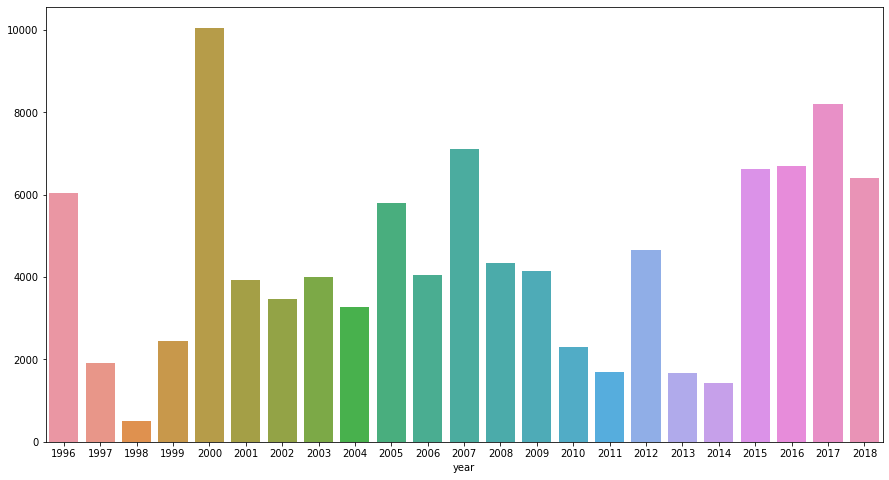

In [4]:
ygroup = df.groupby(['year']).timestamp.count()
plt.figure(figsize=(15,8))
sns.barplot(ygroup.index, ygroup.values)

In [5]:
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit

X = df.drop('userId', 1)
y = df['userId']

#각 연도별 80%는 train, 20%는 test set으로 사용
gs = StratifiedShuffleSplit(n_splits=2, test_size=.2, random_state=42)
train_idx, test_idx = next(gs.split(X, y, groups=X.year))

/var/folders/nb/n8_ktznx1fzdn8kyqtfgy1w40000gn/T/ipykernel_60587/8760459.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop('userId', 1)


In [6]:
len(test_idx)

20168

In [7]:
df['movieId'] = df['movieId'].astype(str)

In [8]:
df_train = df.iloc[train_idx]
df_test = df.iloc[test_idx]

print("train data : {}".format(len(df_train)))
print("test data : {}".format(len(df_test)))

train data : 80668
test data : 20168


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

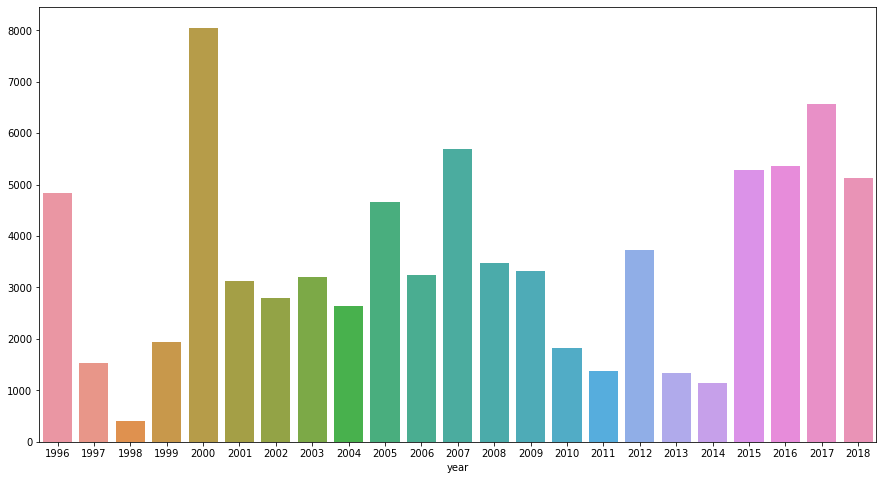

In [9]:
#df_train의 연도별 분포 y값이 df의 80% 수준임을 확인
ygroup_train = df_train.groupby(['year']).timestamp.count()
plt.figure(figsize=(15,8))
sns.barplot(ygroup_train.index, ygroup_train.values)

In [10]:
df_train.head()

,userId,movieId,rating,timestamp,ym,year
75883,477,8529,4.0,2008-01-21 18:47:47,2008-01,2008
59962,387,6270,3.5,2004-09-11 04:13:46,2004-09,2004
61213,401,3114,3.0,2017-11-12 01:09:51,2017-11,2017
95304,600,1270,4.5,2009-03-22 08:49:03,2009-03,2009
3735,22,33794,2.5,2010-03-16 08:03:43,2010-03,2010


In [11]:
train_groupby = df_train.groupby(['userId'])
uid_train = [] #user id의 리스트
doc_train = [] #user가 본 movieId를 각각 document로 정의

for uid, mdf in train_groupby :
    docs = mdf.sort_values(['rating', 'movieId'], ascending=[False, True]).movieId.tolist() #doc 내 movieId 배치 순서
    uid_train.append(uid)
    doc_train.append(docs)

### Topic Modeling - LDA

In [13]:
dictionary = corpora.Dictionary(doc_train)
corpus = [dictionary.doc2bow(doc) for doc in doc_train] 

In [14]:
#최적의 Topic 갯수를 찾기 위해 점진적으로 k를 늘린 후, coherence 값이 가장 높게 나오는 k를 선택
#Topic Coherence 관련 설명 : https://bab2min.tistory.com/587

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3): 
    """ Compute c_v coherence for various number of topics
    Parameters: 
    ---------- 
    
    dictionary : Gensim dictionary 
    corpus : Gensim corpus 
    exts : List of input texts 
    limit : Max num of topics 
    
    Returns: 
    ------- 
    model_list : List of LDA topic models 
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics """ 
    coherence_values = [] 
    model_list = [] 
    
    for num_topics in range(start, limit, step): 
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics) 
        model_list.append(model) 
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v') 
        coherence_values.append(coherencemodel.get_coherence()) 
        
    return model_list, coherence_values 

def find_optimal_number_of_topics(dictionary, corpus, processed_data): 
    limit = 40
    start = 2
    step = 6
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step) 
    
    
    x = range(start, limit, step) 
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score") 
    plt.legend(("coherence_values"), loc='best') 
    
    plt.show()

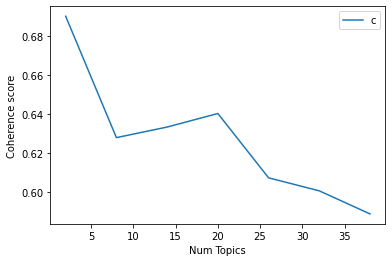

In [15]:
# 최적의 토픽 수 찾기 
find_optimal_number_of_topics(dictionary, corpus, doc_train)

In [16]:
# Topic num = 8
perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell') 
coherence_logger = CoherenceMetric(corpus=corpus, coherence="u_mass", logger='shell') 

#lda 모델 학습
lda_model = LdaModel(corpus, id2word=dictionary, num_topics=8, passes=5, callbacks=[coherence_logger, perplexity_logger]) 

#토픽 대표(상위)단어 5개 포함
topics = lda_model.print_topics(num_words=5)

for topic in topics :
    print(topic)

(0, '0.002*"2858" + 0.002*"1968" + 0.002*"260" + 0.002*"1265" + 0.002*"1210"')
(1, '0.006*"780" + 0.005*"1" + 0.005*"1073" + 0.004*"648" + 0.004*"141"')
(2, '0.007*"2571" + 0.006*"318" + 0.006*"79132" + 0.006*"4993" + 0.005*"7153"')
(3, '0.003*"5952" + 0.003*"2571" + 0.002*"4993" + 0.002*"356" + 0.002*"7153"')
(4, '0.001*"260" + 0.001*"1387" + 0.001*"1196" + 0.001*"4226" + 0.001*"858"')
(5, '0.003*"2959" + 0.003*"4973" + 0.003*"296" + 0.003*"2571" + 0.003*"58559"')
(6, '0.007*"110" + 0.007*"356" + 0.007*"480" + 0.007*"296" + 0.007*"380"')
(7, '0.003*"593" + 0.003*"924" + 0.002*"1196" + 0.002*"356" + 0.002*"1198"')


In [17]:
# Compute Coherence Score using cv 
coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_train, dictionary=dictionary, coherence='c_v') 
coherence_lda = coherence_model_lda.get_coherence() 
print('\nCoherence Score (c_v): ', coherence_lda)


Coherence Score (c_v):  0.6042948544097573


In [18]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

lda_visualization = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False) 
#pyLDAvis.display(lda_visualization)
pyLDAvis.save_html(lda_visualization, "uid_tm_lda_vis.html")

/usr/local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is dep

In [19]:
# movieId -> movie Title
mid_title_dict = {}
df_movies = pd.read_csv("../data/MovieLens/movies.csv")

for row in df_movies.itertuples(index = False) :
    mid_title_dict[row.movieId] = row.title

In [20]:
# User가 어떤 Topic에 묶이는지 hard clustering
# User가 실제 본 영화의 갯수와 Topic Modeling 결과를 활용하여 Topic Score 계산
from math import log10

train_index = [x[0] for x in train_groupby]
uid_lda_dict = {}
uid_topic_train = {}

for uid, doc in zip(train_index, doc_train) :
    res_lda = lda_model.get_document_topics(dictionary.doc2bow(doc))
    uid_lda_dict[uid] = res_lda
    lda_top = sorted(res_lda, key = lambda x : -x[1])[0]
    topic_h = lda_top[0]
    topic_score = log10(1 + (lda_top[1] * len(doc)))
    uid_topic_train[uid] = (topic_h, topic_score)
    

In [21]:
# UserId : 1 의 Topic 연관도
uid_lda_dict[1]

[(0, 0.48181662), (6, 0.51416624)]

In [22]:
# UserId : 1 의 Topic score
uid_topic_train[1]

(6, 1.9851340909243698)

In [23]:
#각 Topic별 대표 단어(여기선 movieId) 추출
for i in range(8) :
    print("Topic {}".format(i))
    tops = lda_model.show_topic(topicid= i)
    for movie in tops :
        print(mid_title_dict[int(movie[0])])
    print()

Topic 0
American Beauty (1999)
Breakfast Club, The (1985)
Star Wars: Episode IV - A New Hope (1977)
Groundhog Day (1993)
Star Wars: Episode VI - Return of the Jedi (1983)
Monty Python and the Holy Grail (1975)
Back to the Future (1985)
Rear Window (1954)
Matrix, The (1999)
Star Wars: Episode V - The Empire Strikes Back (1980)

Topic 1
Independence Day (a.k.a. ID4) (1996)
Toy Story (1995)
Willy Wonka & the Chocolate Factory (1971)
Mission: Impossible (1996)
Birdcage, The (1996)
Twister (1996)
Rock, The (1996)
Star Trek: First Contact (1996)
Broken Arrow (1996)
Executive Decision (1996)

Topic 2
Matrix, The (1999)
Shawshank Redemption, The (1994)
Inception (2010)
Lord of the Rings: The Fellowship of the Ring, The (2001)
Lord of the Rings: The Return of the King, The (2003)
Dark Knight, The (2008)
Forrest Gump (1994)
Lord of the Rings: The Two Towers, The (2002)
Fight Club (1999)
Silence of the Lambs, The (1991)

Topic 3
Lord of the Rings: The Two Towers, The (2002)
Matrix, The (1999)
Lor

## Item2Vec

Word2Vec 라이브러리를 사용해 Item2Vec 생성

doc의 word 배치가 크게 의미를 띄고 있지 않기에, window를 최대한 크게 설정하여 학습

In [24]:
#Word2Vec 모델 생성
model = Word2Vec(doc_train, vector_size=100, window=99999, epochs=40, min_count=0, workers=4)

In [25]:
model.wv['1'] #100 차원의 벡터로 임베딩

array([ 1.1363497 ,  2.929     , -1.0292051 , -1.3476765 , -1.1999801 ,
       -4.5462093 ,  0.18390222,  2.1894987 ,  0.60943085,  0.63959765,
        2.9243605 , -1.3710035 ,  3.0886152 , -0.8641165 ,  0.13359879,
        0.1688361 , -0.40774098, -1.0465521 ,  0.26938874, -0.9638515 ,
       -2.9778504 , -2.5053222 ,  3.109922  ,  2.6912863 , -3.6370814 ,
        1.5533545 , -3.6910336 , -0.9809331 , -2.4141192 , -2.6192136 ,
       -1.2339271 , -0.6950246 ,  5.3174186 ,  0.38590685, -2.2341635 ,
        0.77606714, -3.9602435 , -0.542797  , -2.2814004 , -0.17659707,
        1.6443926 ,  0.74414563, -1.4904486 ,  2.1955116 , -0.8115062 ,
       -3.9437296 , -2.0479407 ,  0.62226474, -1.2852107 , -0.61415285,
       -0.73169017, -4.2490544 ,  7.084808  ,  2.9498172 ,  2.8447006 ,
       -0.50566673,  1.2441591 ,  0.853295  ,  0.08964381, -3.975165  ,
       -0.8401894 , -3.242394  ,  2.45256   ,  3.1306858 , -2.6424878 ,
        2.2404618 , -1.3954593 , -3.6125584 , -5.5389004 , -2.12

In [89]:
model.wv.most_similar(['1']) # movieID : 1 (Toy Story) 와 유사도가 가장 높은 영화 top 10

[('1197', 0.7552919387817383),
 ('1198', 0.742245078086853),
 ('105468', 0.7276507019996643),
 ('1031', 0.7264411449432373),
 ('3674', 0.7128931283950806),
 ('2742', 0.7118198275566101),
 ('4445', 0.7057178616523743),
 ('5560', 0.7044817209243774),
 ('188301', 0.7043879628181458),
 ('1269', 0.7020049095153809)]

In [90]:
mid_title_dict[1]

'Toy Story (1995)'

In [39]:
# movieId -> 영화 타이틀로 변환하여 결과 탐색
title_mid_dict = {v : k for k, v in mid_title_dict.items()}

def get_similar_topn(title, n = 10, with_sim = True) :
    mid = title_mid_dict.get(title, 0)
    if mid == 0 :
        return -1
    
    sims = model.wv.most_similar([str(mid)], topn = n)
    sims = [(mid_title_dict[int(movieid)], round(score, 4)) for (movieid, score) in sims]
    if with_sim :
        return sims
    else :
        return [x[0] for x in sims]

In [88]:
get_similar_topn('Incredible Hulk, The (2008)')

[('Iron Man 2 (2010)', 0.8952),
 ('Guardians of the Galaxy 2 (2017)', 0.838),
 ('Thor (2011)', 0.8374),
 ('Tron: Legacy (2010)', 0.8227),
 ('Doctor Strange (2016)', 0.8182),
 ('Thor: Ragnarok (2017)', 0.8105),
 ('Rogue One: A Star Wars Story (2016)', 0.8091),
 ('Ant-Man (2015)', 0.8016),
 ('Despicable Me (2010)', 0.7965),
 ('WALL·E (2008)', 0.7883)]

In [41]:
movies = sorted(model.wv.index_to_key, key = lambda x : x)

for movie in movies[120:130] :
    title = mid_title_dict[int(movie)]
    print("Moive : {}".format(title))
    print("-------------------------------")
    sims = get_similar_topn(title, n = 5, with_sim = False)
    for name in sims :
        print(name)
    print()

Moive : Kings of Summer, The (2013)
-------------------------------
Glory Daze (1995)
Mistress America (2015)
A Most Wanted Man (2014)
The Square (2017)
Copenhagen (2014)

Moive : Purge, The (2013)
-------------------------------
We Are What We Are (2013)
Insidious: Chapter 2 (2013)
Insidious: Chapter 3 (2015)
Snowtown (Snowtown Murders, The) (2011)
Shepherd: Border Patrol, The (2008)

Moive : Rapture-Palooza (2013)
-------------------------------
Pact, The (2012)
Absentia (2011)
My Lucky Stars (Fuk sing go jiu) (1985)
Paranormal Activity 3 (2011)
Take Aim at the Police Van (Sono gosôsha wo nerae: 'Jûsangô taihisen' yori) (1960)

Moive : Bedknobs and Broomsticks (1971)
-------------------------------
Krippendorf's Tribe (1998)
NeverEnding Story, The (1984)
Little Shop of Horrors (1986)
Night of the Comet (1984)
Andre (1994)

Moive : 20 Feet from Stardom (Twenty Feet from Stardom) (2013)
-------------------------------
Man on Wire (2008)
Brother's Keeper (1992)
Unreasonable Man, An (200

## 평가

추천이 잘 되었는지 평가하는 방법?

-> User가 어떤 영화를 봤을때, 연관 영화들을
   1) 대부분 봤고
   2) 추천된 영화에 대한 rating이 기존 영화와 유사할 때 추천이 잘 됐다고 해석할 수 있다.

In [32]:
df_test.sort_values(['userId'])

,userId,movieId,rating,timestamp,ym,year
52,1,1025,5.0,2000-07-30 18:46:31,2000-07,2000
179,1,2700,5.0,2000-07-30 18:16:25,2000-07,2000
186,1,2899,5.0,2000-07-30 18:45:03,2000-07,2000
37,1,648,3.0,2000-07-30 18:42:43,2000-07,2000
197,1,2997,4.0,2000-07-30 18:14:56,2000-07,2000
...,...,...,...,...,...,...
99644,610,1394,5.0,2016-11-19 08:33:23,2016-11,2016
100570,610,96079,4.0,2017-05-03 21:25:54,2017-05,2017
100325,610,60040,3.5,2017-05-03 21:05:56,2017-05,2017
100179,610,43936,3.0,2017-05-03 21:18:08,2017-05,2017


In [92]:
sims_test = model.wv.most_similar([str(1025)], topn = 30)
df[df['userId'] == 1 & df['movieId'].isin([x[0] for x in sims_test])]

,userId,movieId,rating,timestamp,ym,year
35,1,596,5.0,2000-07-30 18:47:18,2000-07,2000
53,1,1029,5.0,2000-07-30 18:47:35,2000-07,2000
56,1,1032,5.0,2000-07-30 18:46:31,2000-07,2000
88,1,1282,5.0,2000-07-30 18:45:03,2000-07,2000
120,1,2018,5.0,2000-07-30 18:08:43,2000-07,2000
136,1,2137,5.0,2000-07-30 18:46:31,2000-07,2000
142,1,2193,4.0,2000-07-30 18:28:30,2000-07,2000
199,1,3034,5.0,2000-07-30 18:46:31,2000-07,2000
217,1,3489,4.0,2000-07-30 18:29:35,2000-07,2000
